<h1>Fine tuning GPT-3 Model<h1>
    <h5>We try to Fine tune OpenAI's GPT-3 models (Ada and Curie) using raw tweets to classify tweets related to CCS<h5>

In [1]:
#importing libraires
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import openai
import dill
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
#load raw tweets dataset
train_df = pd.read_pickle('./train_df.pkl')
test_df = pd.read_pickle('./test_df.pkl')

In [3]:
#Add text labels (since GPT is languge based model)
train_df['label'] = train_df['related_manual'].map({0:'Other',1:'Carbon Capture, Usage and Storage'})
test_df['label'] = test_df['related_manual'].map({0:'Other',1:'Carbon Capture, Usage and Storage'})

In [4]:
train_df['label'].value_counts()

label
Other                                1000
Carbon Capture, Usage and Storage    1000
Name: count, dtype: int64

In [5]:
test_df['label'].value_counts()

label
Carbon Capture, Usage and Storage    250
Other                                250
Name: count, dtype: int64

In [6]:
#Change columns names for matching finetuning format 
train_data = pd.DataFrame({'prompt':train_df.tweet_original,'completion':train_df.label})
test_data = pd.DataFrame({'prompt':test_df.tweet_original,'completion':test_df.label})

In [7]:
test_data['completion'].value_counts()

completion
Carbon Capture, Usage and Storage    250
Other                                250
Name: count, dtype: int64

In [8]:
#Save as json files
train_data.to_json("./train_original.jsonl", orient='records', lines=True)
test_data.to_json("./test_original.jsonl", orient='records', lines=True)

In [8]:
openai.api_key = '*******'

In [10]:
#helper to create training file instance
def create_training_file(file_path):
    file = openai.File.create(
        file=open(file_path, "rb"),
        purpose='fine-tune'
    )
    return file

#create training file instance
training_file_original = create_training_file("./train_original_prepared (1).jsonl")
print(training_file_original)

{
  "object": "file",
  "id": "file-nFn9545yuU9v4zXKtNuO9bqz",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 513531,
  "created_at": 1690882662,
  "status": "uploaded",
  "status_details": null
}


In [11]:
#create fine tuning job for Ada model
fine_tuned_model_1 = openai.FineTune.create(training_file = training_file_original['id'], 
                                            model = "ada", 
                                            n_epochs = 4,
                                            prompt_loss_weight=0.01,
                                            learning_rate_multiplier=0.1,
                                            suffix="original_1-Aug_ada")

In [12]:
#create fine tuning job for Curie model
fine_tuned_model_2 = openai.FineTune.create(training_file = training_file_original['id'], 
                                            model = "curie", 
                                            n_epochs = 4,
                                            prompt_loss_weight=0.01,
                                            learning_rate_multiplier=0.1,
                                            suffix="original_1-Aug_curie")

In [9]:
#helper to predict
def predict(test_data, model_name):
    preds = []
    for item, row in test_data.iterrows():
        tweet = row['prompt']
        res = openai.Completion.create(model=model_name, prompt=tweet, max_tokens=1, temperature=0, logprobs=2)
        prediction = res['choices'][0]['text']
        if prediction==' Carbon':
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [10]:
#helper to generate performance report
def performance(y_true,y_predict):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_predict)
    print(thresholds)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
#JSON files retrieving
test_data_original = pd.read_json("./test_original_prepared (1).jsonl", orient='records', lines=True)

In [12]:
#Mapping back to 0 and 1 for performance report generation
test_data_original['label_binary'] = test_data_original['completion'].map({' Other':0,' Carbon Capture, Usage and Storage':1})
test_data_original['prompt'][3]                                

'For anyone recently reading about wetlands💦&amp; their importance for carbon storage\r\nMangrove forests are amazing places too⤵️\r\n@WetlandLink @WetlandsInt @Mangroves @globalwetlands @dfomangrovefdwl @IUCN_Mangrove @MangroveProject  @danfriess @GabrielPopkin @ErikYando @Barefoot_Lab https://t.co/DoHgnsFAkR\n\n###\n\n'

In [20]:
%%time
#ada predictions
predictions_ada = predict(test_data_original,"ada:ft-heriot-watt-university:original-1-aug-ada-2023-08-01-13-33-29")

CPU times: user 1.58 s, sys: 313 ms, total: 1.89 s
Wall time: 1min 54s


Accuracy: 97.8%
[246   4   7 243]
TP: 246
FP: 7
TN: 243
FN: 4
Sensitivity: 98.4%
Specificity: 97.2%
Precision: 97.233%
Recall: 98.4%
f1: 97.813%


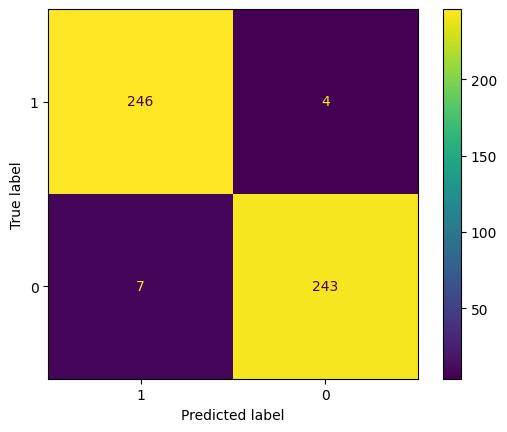

[inf  1.  0.]


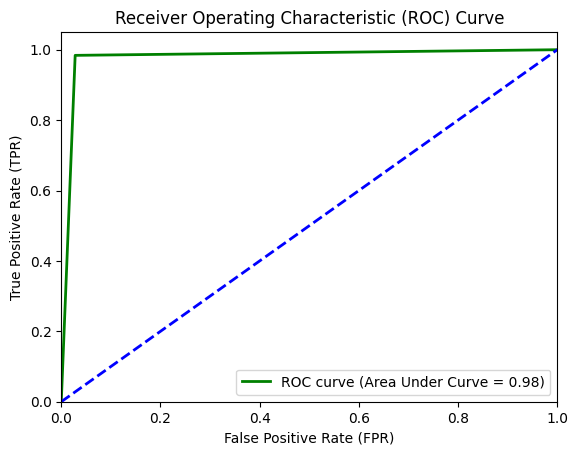

In [16]:
#Ada performance report
performance(test_data_original['label_binary'],predictions_ada)

In [22]:
%%time
#Curie predictions
predictions_curie = predict(test_data_original,"curie:ft-heriot-watt-university:original-1-aug-curie-2023-08-01-13-04-19")

CPU times: user 1.57 s, sys: 260 ms, total: 1.83 s
Wall time: 1min 44s


Accuracy: 97.0%
[248   2  13 237]
TP: 248
FP: 13
TN: 237
FN: 2
Sensitivity: 99.2%
Specificity: 94.8%
Precision: 95.019%
Recall: 99.2%
f1: 97.064%


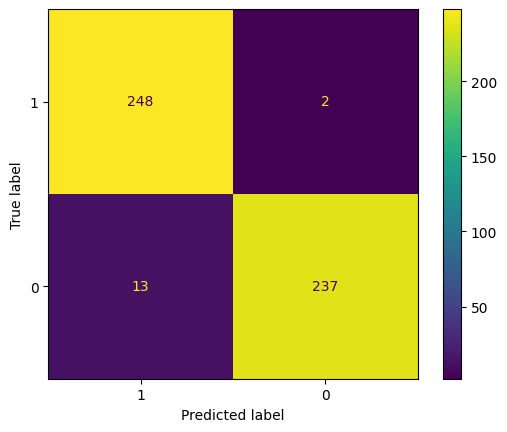

[inf  1.  0.]


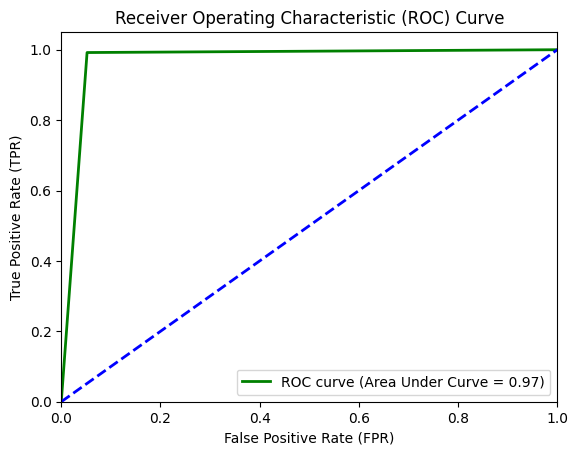

In [23]:
#Curie performance report
performance(test_data_original['label_binary'],predictions_curie)

<h2>Results<h2>
    <h5>In our case Ada model performed better than Curie<h5>
    

| Model       | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|-------------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| GPT - Ada   | 97.8%    | 246 | 7  | 243 | 4  | 98.4%       | 97.2%       | 97.233%   | 98.4%  | 97.813%  |
| GPT - Curie | 97%      | 248 | 13 | 237 | 2  | 99.2%       | 94.8%       | 95.019%   | 99.2%  | 97.064%  |